In [25]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data import load_data_excel, convert_numeric_columns
from src.features import encode_categorical_feature, get_simplified_names
from src.experiments import (
    prepare_data_random_split, prepare_data_hide_one_per_class,
    prepare_data_hide_class, train_xgboost_models, get_hidden_products_info
)
from src.visu import plot_ml_results

# Load data
data = load_data_excel('../data/sources/Donnees_IA_2025.xlsx')

# Define variables
vars_expl = [
    "MS % brut", "PB % brut", "CB % brut", "MGR % brut", "MM % brut",
    "NDF % brut", "ADF % brut", "Lignine % brut", "Amidon % brut", "Sucres % brut"
]

vars_cibles = [
    "EB (kcal) kcal/kg brut", "ED porc croissance (kcal) kcal/kg brut",
    "EM porc croissance (kcal) kcal/kg brut", "EN porc croissance (kcal) kcal/kg brut",
    "EMAn coq (kcal) kcal/kg brut", "EMAn poulet (kcal) kcal/kg brut",
    "UFL 2018 par kg brut", "UFV 2018 par kg brut", "PDIA 2018 g/kg brut",
    "PDI 2018 g/kg brut", "BalProRu 2018 g/kg brut"
]

# Convert numeric columns
data = convert_numeric_columns(data, vars_expl + vars_cibles)

# Get simplified names
simplified_names = get_simplified_names()

print(f" Data loaded: {len(data)} observations")

 Data loaded: 6376 observations


## Out-Of-Distribution (OOD) Robustness Testing

Test model generalization by hiding products/classes during training and evaluating on held-out data.

### Baseline: In-Distribution Random Split (IID)

In [26]:
# IID Baseline with stratification by Nom - MULTI-SEED EVALUATION (10 seeds)
from sklearn.model_selection import train_test_split

iid_all_runs = []

print("\n" + "="*80)
print("BASELINE: In-Distribution (IID) Random Split with Stratification by Nom")
print("Multi-Seed Evaluation (10 seeds for comparability with OOD)")
print("="*80)
print("Configuration: 10 random seeds\n")

# Run IID with 10 different seeds
for seed in range(10):
    # Get all indices
    all_indices = np.arange(len(data))
    
    # Stratified split by Nom
    train_indices, test_indices = train_test_split(
        all_indices,
        test_size=0.2,
        random_state=seed,  # Different seed each time
        stratify=data['Nom'].values
    )
    
    X_train_iid = data.iloc[train_indices][vars_expl].reset_index(drop=True)
    X_test_iid = data.iloc[test_indices][vars_expl].reset_index(drop=True)
    y_train_iid = data.iloc[train_indices][vars_cibles].reset_index(drop=True)
    y_test_iid = data.iloc[test_indices][vars_cibles].reset_index(drop=True)
    
    results_iid, metrics_iid, models_iid = train_xgboost_models(
        X_train_iid, X_test_iid, y_train_iid, y_test_iid,
        vars_cibles, simplified_names, random_state=seed
    )
    
    r2_score = metrics_iid['R2_variance_weighted']
    iid_all_runs.append({
        'Seed': seed,
        'R² Variance Weighted': r2_score
    })
    
    print(f"Seed {seed}: R² = {r2_score:.4f}")

# Convert to DataFrame
iid_df = pd.DataFrame(iid_all_runs)

# Calculate statistics
mean_r2_iid = iid_df['R² Variance Weighted'].mean()
std_r2_iid = iid_df['R² Variance Weighted'].std()
ci_95_iid = 1.96 * std_r2_iid / np.sqrt(len(iid_df))

print(f"\nIID BASELINE STATISTICS")
print(f"  Mean R²: {mean_r2_iid:.4f}")
print(f"  Std Dev: {std_r2_iid:.4f}")
print(f"  95% CI: [{mean_r2_iid - ci_95_iid:.4f}, {mean_r2_iid + ci_95_iid:.4f}]")
print(f"  Total runs: {len(iid_df)}")


BASELINE: In-Distribution (IID) Random Split with Stratification by Nom
Multi-Seed Evaluation (10 seeds for comparability with OOD)
Configuration: 10 random seeds

Seed 0: R² = 0.9903
Seed 1: R² = 0.9897
Seed 2: R² = 0.9909
Seed 3: R² = 0.9908
Seed 4: R² = 0.9897
Seed 5: R² = 0.9910
Seed 6: R² = 0.9915
Seed 7: R² = 0.9913
Seed 8: R² = 0.9913
Seed 9: R² = 0.9915

IID BASELINE STATISTICS
  Mean R²: 0.9908
  Std Dev: 0.0007
  95% CI: [0.9904, 0.9912]
  Total runs: 10


### OOD Scenario 1: Hide 1 Random Product (Multiple Seeds & Products)
**Improved Protocol:**
- Multiple seeds (10 runs) for statistical robustness
- For each seed, test hiding N different products and average results
- Calculate 95% confidence intervals
- Perform paired t-test vs IID baseline to assess significance

In [27]:
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# OOD Scenario 1: Hide 1 random product with MULTIPLE SEEDS and PRODUCTS
# Parameters
num_seeds = 10
products_per_seed = min(3, len(data['Nom'].unique()))  # Test 3 different products per seed (or less if fewer products)

ood1_all_runs = []
ood1_seed_results = {}

print("\n" + "="*80)
print("OOD SCENARIO 1: Hide 1 Random Product - ROBUST EVALUATION")
print("="*80)
print(f"Configuration: {num_seeds} seeds × {products_per_seed} products per seed")
print(f"Total runs: {num_seeds * products_per_seed}\n")

unique_noms = data['Nom'].unique()

for seed in range(num_seeds):
    rng = np.random.RandomState(seed)
    seed_results = []
    
    # Select N different products to hide for this seed
    products_to_test = rng.choice(unique_noms, size=products_per_seed, replace=False)
    
    for nom_to_hide in products_to_test:
        X_train_ood1 = data[data['Nom'] != nom_to_hide][vars_expl].reset_index(drop=True)
        X_test_ood1 = data[data['Nom'] == nom_to_hide][vars_expl].reset_index(drop=True)
        y_train_ood1 = data[data['Nom'] != nom_to_hide][vars_cibles].reset_index(drop=True)
        y_test_ood1 = data[data['Nom'] == nom_to_hide][vars_cibles].reset_index(drop=True)
        
        if len(X_test_ood1) >= 1:
            results_ood1, metrics_ood1, models_ood1 = train_xgboost_models(
                X_train_ood1, X_test_ood1, y_train_ood1, y_test_ood1,
                vars_cibles, simplified_names, random_state=seed
            )
            
            r2_score = metrics_ood1['R2_variance_weighted']
            performance_drop = r2_score - metrics_iid['R2_variance_weighted']
            
            seed_results.append({
                'Seed': seed,
                'Hidden Product': nom_to_hide,
                'Test Size': len(X_test_ood1),
                'R² Variance Weighted': r2_score,
                'Performance Drop': performance_drop
            })
            ood1_all_runs.append({
                'Seed': seed,
                'Hidden Product': nom_to_hide,
                'R² Variance Weighted': r2_score,
                'Performance Drop': performance_drop
            })
    
    ood1_seed_results[seed] = seed_results
    
    # Print progress
    seed_avg_r2 = np.mean([r['R² Variance Weighted'] for r in seed_results])
    print(f"Seed {seed:2d}: avg R² = {seed_avg_r2:.4f} (tested products: {', '.join(products_to_test)})")

# Convert to DataFrame for analysis
ood1_df = pd.DataFrame(ood1_all_runs)

print("\n" + "="*80)
print("SCENARIO 1: STATISTICAL SUMMARY")
print("="*80)

# Calculate statistics
mean_r2 = ood1_df['R² Variance Weighted'].mean()
std_r2 = ood1_df['R² Variance Weighted'].std()
ci_95 = 1.96 * std_r2 / np.sqrt(len(ood1_df))  # 95% confidence interval
min_r2 = ood1_df['R² Variance Weighted'].min()
max_r2 = ood1_df['R² Variance Weighted'].max()

mean_drop = ood1_df['Performance Drop'].mean()
std_drop = ood1_df['Performance Drop'].std()
ci_95_drop = 1.96 * std_drop / np.sqrt(len(ood1_df))

print(f"\nR² Variance Weighted:")
print(f"  Mean: {mean_r2:.4f}")
print(f"  Std Dev: {std_r2:.4f}")
print(f"  95% CI: [{mean_r2 - ci_95:.4f}, {mean_r2 + ci_95:.4f}]")
print(f"  Min: {min_r2:.4f}, Max: {max_r2:.4f}")
print(f"  Range: {max_r2 - min_r2:.4f}")

print(f"\nPerformance Drop vs IID Baseline:")
print(f"  Mean drop: {mean_drop:+.4f}")
print(f"  Std Dev: {std_drop:.4f}")
print(f"  95% CI: [{mean_drop - ci_95_drop:+.4f}, {mean_drop + ci_95_drop:+.4f}]")

# Paired t-test: OOD1 vs IID (compare mean_r2 to IID R²)
iid_r2 = metrics_iid['R2_variance_weighted']
print(f"\nComparison to IID Baseline (R² = {iid_r2:.4f}):")
print(f"  Difference: {mean_r2 - iid_r2:+.4f}")

# One-sample t-test: is the drop significant?
t_stat, p_value = stats.ttest_1samp(ood1_df['Performance Drop'], 0)
print(f"\n  One-sample t-test (H0: drop = 0):")
print(f"    t-statistic: {t_stat:.4f}")
print(f"    p-value: {p_value:.4f}")
if p_value < 0.05:
    print(f"    ✓ Performance drop IS statistically significant (p < 0.05)")
else:
    print(f"    ✗ Performance drop is NOT statistically significant (p >= 0.05)")

print(f"\nTotal runs analyzed: {len(ood1_df)}")


OOD SCENARIO 1: Hide 1 Random Product - ROBUST EVALUATION
Configuration: 10 seeds × 3 products per seed
Total runs: 30

Seed  0: avg R² = -0.2550 (tested products: Son de maïs, Son de riz, huile < 5 %, Pois)
Seed  1: avg R² = -7.6814 (tested products: Maïs, Graine de colza, Farine de poisson (toutes))
Seed  2: avg R² = -9.7475 (tested products: Paille de blé, Tourteau de germes de maïs, huile < 5 %, Blé tendre)
Seed  3: avg R² = -22.7278 (tested products: Drêches de blé de distillerie, amidon > 7 %, Graine de tournesol, Pulpe de betterave déshydratée)
Seed  4: avg R² = -1.9967 (tested products: Drêches de maïs de distillerie avec solubles, déshydratées, huile < 6 %, protéines < 30 %, Graine de lin, Lactosérum réengraissé)
Seed  5: avg R² = -3.3737 (tested products: Tourteau de palmiste, huile 5-20%, Lactosérum réengraissé, Tourteau de lin, huile > 5 %)
Seed  6: avg R² = -4.3747 (tested products: Tourteau de colza, huile < 5 %, Amidon de maïs, Tourteau de tournesol, huile > 5 %)
Seed  

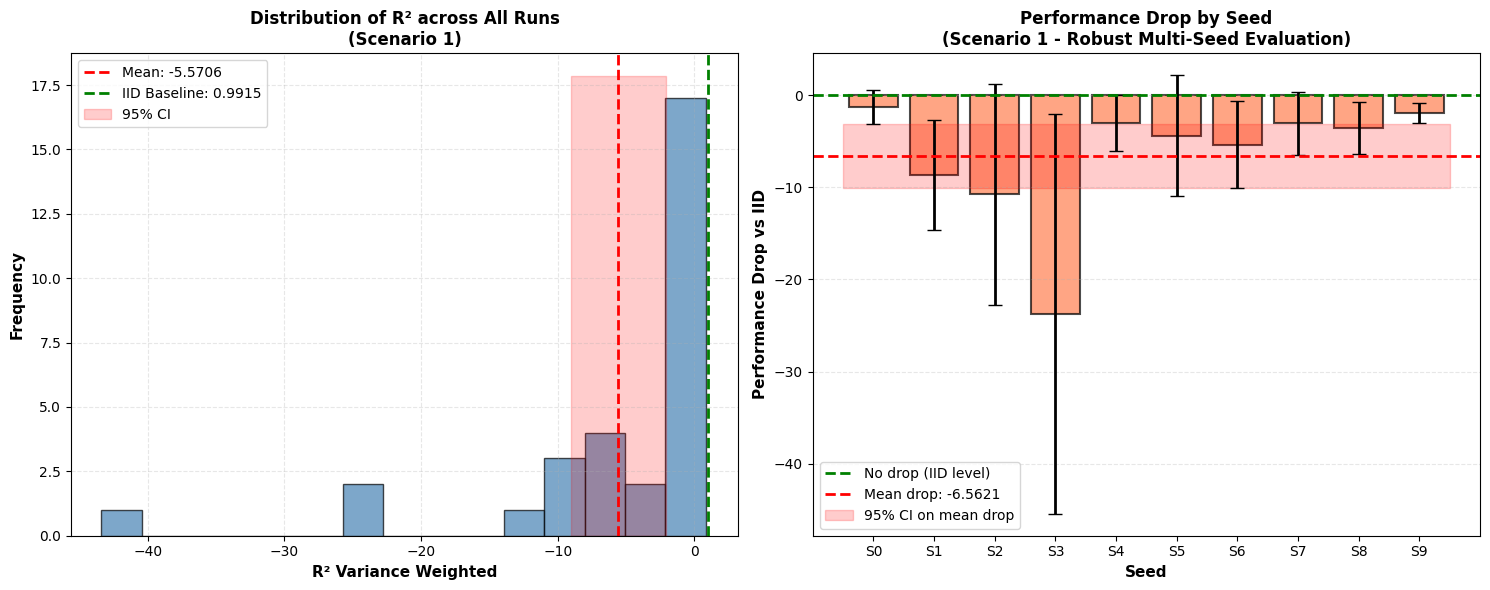


SCENARIO 1: DETAILED RESULTS BY SEED
     R² Variance Weighted                           Performance Drop         
                     mean      std      min     max             mean      std
Seed                                                                         
0                 -0.2550   1.8566  -2.3988  0.8235          -1.2465   1.8566
1                 -7.6814   5.9831 -12.1041 -0.8736          -8.6729   5.9831
2                 -9.7475  11.9823 -23.1886 -0.1846         -10.7390  11.9823
3                -22.7278  21.7231 -43.3858 -0.0770         -23.7193  21.7231
4                 -1.9967   3.0257  -5.4170  0.3307          -2.9882   3.0257
5                 -3.3737   6.5649 -10.9536  0.5018          -4.3652   6.5649
6                 -4.3747   4.7433  -9.1273  0.3592          -5.3662   4.7433
7                 -2.0474   3.4465  -6.0270 -0.0319          -3.0389   3.4465
8                 -2.5716   2.8563  -5.8693 -0.8736          -3.5631   2.8563
9                 -0.9298 

In [28]:
# Visualization of Scenario 1 with Confidence Intervals
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: R² distribution across all runs
ax = axes[0]
ax.hist(ood1_df['R² Variance Weighted'], bins=15, alpha=0.7, color='steelblue', 
        edgecolor='black', density=False)
ax.axvline(mean_r2, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_r2:.4f}')
ax.axvline(iid_r2, color='green', linestyle='--', linewidth=2, label=f'IID Baseline: {iid_r2:.4f}')
ax.fill_betweenx([0, ax.get_ylim()[1]], mean_r2 - ci_95, mean_r2 + ci_95, 
                  alpha=0.2, color='red', label='95% CI')
ax.set_xlabel('R² Variance Weighted', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Distribution of R² across All Runs\n(Scenario 1)', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3, linestyle='--')

# Plot 2: Performance drop by seed
ax = axes[1]
seed_means = ood1_df.groupby('Seed')['Performance Drop'].mean()
seed_stds = ood1_df.groupby('Seed')['Performance Drop'].std()

x_pos = np.arange(len(seed_means))
ax.bar(x_pos, seed_means, yerr=seed_stds, alpha=0.7, color='coral', 
       edgecolor='black', linewidth=1.5, capsize=5, error_kw={'linewidth': 2})
ax.axhline(0, color='green', linestyle='--', linewidth=2, label='No drop (IID level)')
ax.axhline(mean_drop, color='red', linestyle='--', linewidth=2, label=f'Mean drop: {mean_drop:+.4f}')
ax.fill_between([-0.5, len(seed_means) - 0.5], 
                mean_drop - ci_95_drop, mean_drop + ci_95_drop,
                alpha=0.2, color='red', label='95% CI on mean drop')

ax.set_xlabel('Seed', fontsize=11, fontweight='bold')
ax.set_ylabel('Performance Drop vs IID', fontsize=11, fontweight='bold')
ax.set_title('Performance Drop by Seed\n(Scenario 1 - Robust Multi-Seed Evaluation)', 
             fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'S{i}' for i in range(num_seeds)])
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*80)
print("SCENARIO 1: DETAILED RESULTS BY SEED")
print("="*80)
seed_summary = ood1_df.groupby('Seed').agg({
    'R² Variance Weighted': ['mean', 'std', 'min', 'max'],
    'Performance Drop': ['mean', 'std']
}).round(4)
print(seed_summary)


In [29]:
# Formal Statistical Test: IID vs Scenario 1
print("\n" + "="*80)
print("STATISTICAL SIGNIFICANCE TEST: IID vs SCENARIO 1")
print("="*80)

# Create a comparison: for each OOD1 run, compare against IID
# (We use IID baseline as a fixed value to compare against)
ood1_r2_values = ood1_df['R² Variance Weighted'].values
iid_r2_value = metrics_iid['R2_variance_weighted']

# Paired comparison (each OOD1 run vs the single IID baseline)
# We'll use one-sample t-test on the differences
differences = ood1_r2_values - iid_r2_value

print(f"\nIID Baseline R²: {iid_r2_value:.4f}")
print(f"OOD Scenario 1 Mean R²: {mean_r2:.4f}")
print(f"Mean Difference: {np.mean(differences):+.4f}")
print(f"Std of Differences: {np.std(differences):.4f}")

# Welch's t-test (doesn't assume equal variances)
t_stat_welch, p_value_welch = stats.ttest_1samp(differences, 0)
print(f"\nWelch's One-Sample t-test (H0: difference = 0):")
print(f"  t-statistic: {t_stat_welch:.4f}")
print(f"  p-value: {p_value_welch:.6f}")
print(f"  Degrees of freedom: {len(differences) - 1}")

# Effect size (Cohen's d)
cohens_d = np.mean(differences) / np.std(differences)
print(f"\nEffect Size (Cohen's d): {cohens_d:.4f}")
if abs(cohens_d) < 0.2:
    effect_interpretation = "negligible"
elif abs(cohens_d) < 0.5:
    effect_interpretation = "small"
elif abs(cohens_d) < 0.8:
    effect_interpretation = "medium"
else:
    effect_interpretation = "large"
print(f"  Interpretation: {effect_interpretation}")

# Conclusion
alpha = 0.05
print(f"\nConclusion (α = {alpha}):")
if p_value_welch < alpha:
    print(f"  ✓ Scenario 1 performance IS significantly different from IID (p = {p_value_welch:.6f})")
else:
    print(f"  ✗ Scenario 1 performance is NOT significantly different from IID (p = {p_value_welch:.6f})")

if np.mean(differences) < 0:
    print(f"  → OOD Scenario 1 shows a DEGRADATION in performance")
else:
    print(f"  → OOD Scenario 1 shows a IMPROVEMENT in performance (unexpected)")



STATISTICAL SIGNIFICANCE TEST: IID vs SCENARIO 1

IID Baseline R²: 0.9915
OOD Scenario 1 Mean R²: -5.5706
Mean Difference: -6.5621
Std of Differences: 9.5232

Welch's One-Sample t-test (H0: difference = 0):
  t-statistic: -3.7107
  p-value: 0.000872
  Degrees of freedom: 29

Effect Size (Cohen's d): -0.6891
  Interpretation: medium

Conclusion (α = 0.05):
  ✓ Scenario 1 performance IS significantly different from IID (p = 0.000872)
  → OOD Scenario 1 shows a DEGRADATION in performance


### OOD Performance Summary & Visualization

In [30]:
# Create comparison: IID vs OOD Scenario 1 - R² absolus avec écarts-types comparables
comparison_df = pd.DataFrame([
    {"Scenario": "IID Baseline", "R²": mean_r2_iid, "Std": std_r2_iid, "CI": ci_95_iid},
    {"Scenario": "OOD: Hide 1 Product", "R²": mean_r2, "Std": std_r2, "CI": ci_95}
])

print("\n" + "="*80)
print("IID vs OOD SCENARIO 1 COMPARISON - R² ABSOLUS")
print("="*80)
print(f"IID Baseline:")
print(f"  Mean R²: {mean_r2_iid:.4f}")
print(f"  Std Dev: {std_r2_iid:.4f}")
print(f"  95% CI: ± {ci_95_iid:.4f}")
print(f"  N runs: {len(iid_df)}")
print(f"\nOOD Scenario 1:")
print(f"  Mean R²: {mean_r2:.4f}")
print(f"  Std Dev: {std_r2:.4f}")
print(f"  95% CI: ± {ci_95:.4f}")
print(f"  N runs: {len(ood1_df)}")
print(f"\nPerformance Drop: {mean_r2 - mean_r2_iid:+.4f}")
print("\n" + comparison_df.to_string(index=False))


IID vs OOD SCENARIO 1 COMPARISON - R² ABSOLUS
IID Baseline:
  Mean R²: 0.9908
  Std Dev: 0.0007
  95% CI: ± 0.0004
  N runs: 10

OOD Scenario 1:
  Mean R²: -5.5706
  Std Dev: 9.6860
  95% CI: ± 3.4661
  N runs: 30

Performance Drop: -6.5614

           Scenario       R²      Std       CI
       IID Baseline  0.99080 0.000683 0.000423
OOD: Hide 1 Product -5.57056 9.686000 3.466091


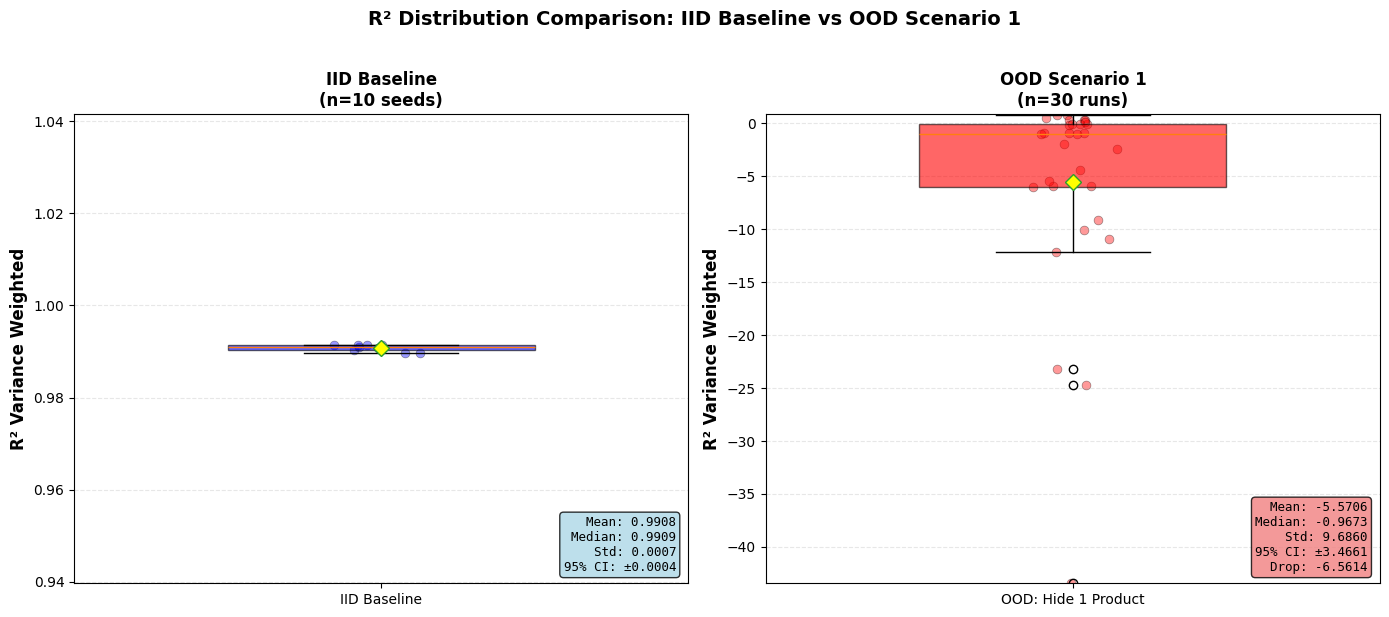

In [35]:
# Visualization: IID vs OOD Scenario 1 - Separate plots for clarity
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# LEFT PLOT: IID Baseline
ax1 = axes[0]
iid_data = iid_df['R² Variance Weighted'].values

bp1 = ax1.boxplot([iid_data], 
                   labels=['IID Baseline'],
                   patch_artist=True,
                   widths=0.5,
                   showmeans=True,
                   meanprops=dict(marker='D', markerfacecolor='yellow', markersize=8))

# Color the box
for patch in bp1['boxes']:
    patch.set_facecolor('blue')
    patch.set_alpha(0.6)

# Overlay individual points with jitter
x_jitter = np.random.normal(1, 0.04, size=len(iid_data))
ax1.scatter(x_jitter, iid_data, alpha=0.4, s=40, color='blue', edgecolors='black', linewidth=0.5)

ax1.set_ylabel('R² Variance Weighted', fontsize=12, fontweight='bold')
ax1.set_title(f'IID Baseline\n(n={len(iid_df)} seeds)', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add stats to IID plot
iid_stats = f"""Mean: {mean_r2_iid:.4f}
Median: {iid_df['R² Variance Weighted'].median():.4f}
Std: {std_r2_iid:.4f}
95% CI: ±{ci_95_iid:.4f}"""

ax1.text(0.98, 0.02, iid_stats, transform=ax1.transAxes, 
         fontsize=9, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
         family='monospace')

# Set y-axis limits for IID
y_min_iid = np.min(iid_data) - 0.05
y_max_iid = np.max(iid_data) + 0.05
ax1.set_ylim([y_min_iid, y_max_iid])

# RIGHT PLOT: OOD Scenario 1
ax2 = axes[1]
ood_data = ood1_df['R² Variance Weighted'].values

bp2 = ax2.boxplot([ood_data], 
                   labels=['OOD: Hide 1 Product'],
                   patch_artist=True,
                   widths=0.5,
                   showmeans=True,
                   meanprops=dict(marker='D', markerfacecolor='yellow', markersize=8))

# Color the box
for patch in bp2['boxes']:
    patch.set_facecolor('red')
    patch.set_alpha(0.6)

# Overlay individual points with jitter
x_jitter = np.random.normal(1, 0.04, size=len(ood_data))
ax2.scatter(x_jitter, ood_data, alpha=0.4, s=40, color='red', edgecolors='black', linewidth=0.5)

ax2.set_ylabel('R² Variance Weighted', fontsize=12, fontweight='bold')
ax2.set_title(f'OOD Scenario 1\n(n={len(ood1_df)} runs)', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add stats to OOD plot
ood_stats = f"""Mean: {mean_r2:.4f}
Median: {ood1_df['R² Variance Weighted'].median():.4f}
Std: {std_r2:.4f}
95% CI: ±{ci_95:.4f}
Drop: {mean_r2 - mean_r2_iid:+.4f}"""

ax2.text(0.98, 0.02, ood_stats, transform=ax2.transAxes, 
         fontsize=9, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8),
         family='monospace')

# Set y-axis limits for OOD
y_min_ood = np.min(ood_data) - 0.05
y_max_ood = np.max(ood_data) + 0.05
ax2.set_ylim([y_min_ood, y_max_ood])

fig.suptitle('R² Distribution Comparison: IID Baseline vs OOD Scenario 1', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('../reports/figures/ood_comparaison_iid_ood1.png')
plt.show()